In [1]:
import sys 
import os
import cymetric as cym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
import cymetric
import pyne
pd.options.display.precision = 16

%matplotlib inline

In [2]:
### weak point....need to have these variables in a file that input + analysis both use ###
add_intro = 12*5
trans_sfr = 12*15

impt_times = [add_intro, trans_sfr]

In [142]:
#db = cym.dbopen('../output/01_full-add_flat-pwr.sqlite')
#db = cym.dbopen('../output/01_full-add_grow-pwr.sqlite')
#db = cym.dbopen('../output/01_ramp-add_flat-pwr.sqlite') # not working, sim fails
#db = cym.dbopen('../output/01_ramp-add_grow-pwr.sqlite') # not working, sim fails
#db = cym.dbopen('../output/23_full-add_flat-pwr.sqlite')
#db = cym.dbopen('../output/bam_23_full-add_grow-pwr.sqlite') # not working, bad power curve
db = cym.dbopen('../output/eg01_grow_250000000_250000_0.0.sqlite')

ev = cym.Evaluator(db=db, write=False)

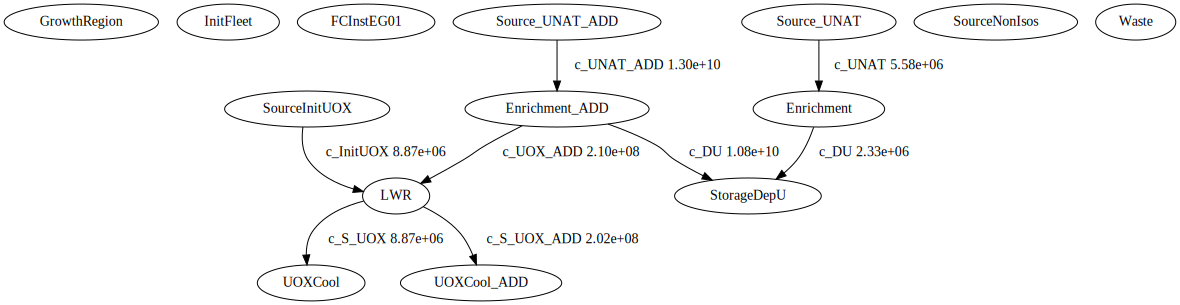

In [143]:
d = cgr.flow_graph(ev, label=['com', 'mass'], start=0)
#d.render('eg23',format='png', view=True)
d

# Time Series Power

In [144]:
trans_sfr = 12*25

def pwr_plt(dfs):
    ax = dfs[0].plot(x='Year', figsize=(9,5), legend=False)

    
    for df in dfs[1:]:
        df.plot(x='Year', figsize=(9,5), legend=False, ax=ax)
    plt.xlabel(r'Year', fontsize=20)
    plt.ylabel(r'Power [GWe]',fontsize=20)
    ax.minorticks_on()
    #ax.set_ylim(-9, 281)
    #ax.set_xlim(0, 100)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.grid()
    plt.show()
    return

def tr_plt(dfs, label=r'Transaction [t]'):
    ax = dfs[0].plot(x='Year', y='Mass', figsize=(9,5), legend=False)

    
    for df in dfs[1:]:
        df.plot(x='Year', y='Mass', figsize=(9,5), legend=False, ax=ax)
    plt.xlabel(r'Year', fontsize=20)
    plt.ylabel(label,fontsize=20)
    ax.minorticks_on()
    #ax.set_ylim(-9, 281)
    #ax.set_xlim(0, 100)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.grid()
    plt.show()
    return

/root/.local/lib/python3.6/site-packages/cymetric/timeseries.py:197: UserWarning: no faciity provided
  warnings.warn(wng_msg, UserWarning)
/root/.local/lib/python3.6/site-packages/cymetric/tools.py:150: UserWarning: Empty  provided for AgentId key.
  warnings.warn(wng_msg, UserWarning)


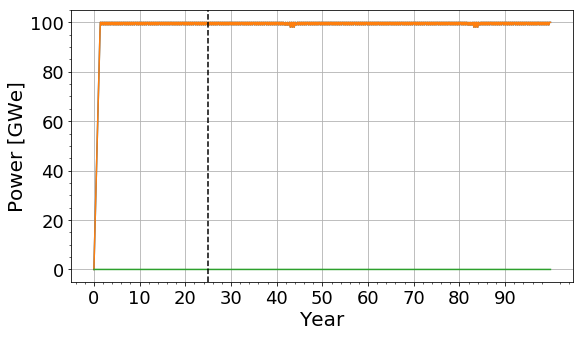

In [145]:
df_tspower = tm.get_power(ev, [])
df_tspower1 = tm.get_power(ev, ['LWR'])
df_tspower2 = tm.get_power(ev, ['SFR'])
df_tspower['Year'] = df_tspower['Time'] / 12.
df_tspower1['Year'] = df_tspower1['Time'] / 12.
df_tspower2['Year'] = df_tspower2['Time'] / 12.
# power in GWe
power = df_tspower.groupby(['Year'])['Value'].sum() / 1000.0
power1 = df_tspower1.groupby(['Year'])['Value'].sum() / 1000.0
power2 = df_tspower2.groupby(['Year'])['Value'].sum() / 1000.0
pwr_plt([power, power1, power2])


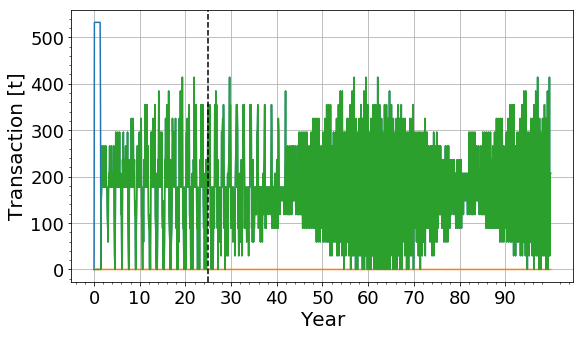

In [146]:
df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
df_tr_PWR['Mass'] = df_tr_PWR['Mass']/1000.
df_tr_PWR_unat = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment'])
df_tr_PWR_unat['Mass'] = df_tr_PWR_unat['Mass']/1000.
df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'])
df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/1000.


df_tr_PWR['Year'] = df_tr_PWR['Time'] / 12.
df_tr_PWR_unat['Year'] = df_tr_PWR_unat['Time'] / 12.
df_tr_PWR_unat_add['Year'] = df_tr_PWR_unat_add['Time'] / 12.

tr_plt([df_tr_PWR, df_tr_PWR_unat, df_tr_PWR_unat_add])


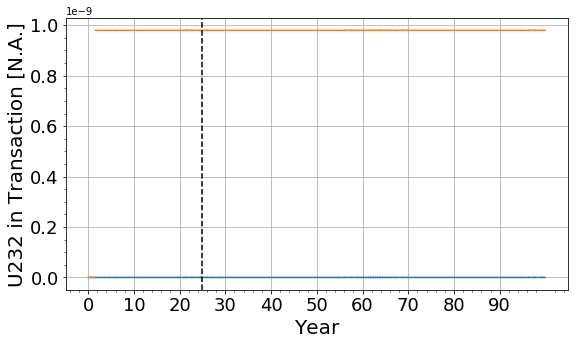

In [147]:
df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
df_tr_PWR['Mass'] = df_tr_PWR['Mass']
df_tr_PWR_unat = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment'], nucs=['922320000'])
df_tr_PWR_unat['Mass'] = df_tr_PWR_unat['Mass']/df_tr_PWR['Mass']
df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'], nucs=['922320000'])
df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/df_tr_PWR['Mass']


df_tr_PWR['Year'] = df_tr_PWR['Time'] / 12.
df_tr_PWR_unat['Year'] = df_tr_PWR_unat['Time'] / 12.
df_tr_PWR_unat_add['Year'] = df_tr_PWR_unat_add['Time'] / 12.

tr_plt([df_tr_PWR_unat, df_tr_PWR_unat_add], label=r'U232 in Transaction [N.A.]')




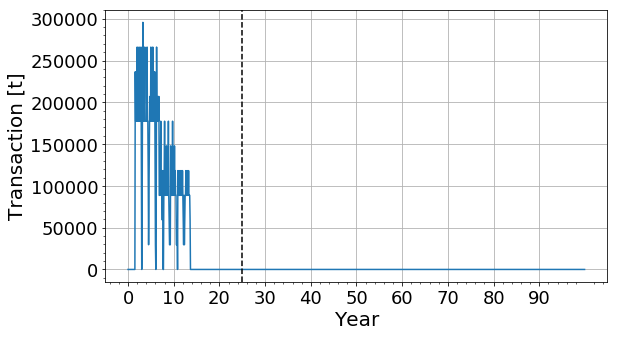

In [141]:
df_tr_PWR_unblended = tm.transactions(ev, senders=['LWR'], receivers=['UOXCool'])
df_tr_PWR_unblended['Year'] = df_tr_PWR_unblended['Time'] / 12.

tr_plt([df_tr_PWR_unblended])


In [31]:
import numpy as np


def found_last_non_zero(pdf):
    eq_year = -1
    not_eq = pdf[pdf['Mass'] > 0]['Time']
    return not_eq.max()+1

def ratio_until(pdf, time=100):
    max_value = pdf['Mass'].max()
    pdf_transition = pdf[pdf['Time'] < time]
    return pdf_transition['Mass'].mean()/max_value

def found_equilibrium(pdf, full_load):
    eq_year = -1
    not_eq = pdf[pdf['Mass'] != full_load['Mass']]['Time']
    return not_eq.max()+1


def get_transition_ratio(output_file):
    db = cym.dbopen(output_file)
    ev = cym.Evaluator(db=db, write=False)

    df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
    df_tr_PWR['Mass'] = df_tr_PWR['Mass']/1000.
    df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'])
    df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/1000.    
    eq_time = found_equilibrium(df_tr_PWR_unat_add, df_tr_PWR)

    
    df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
    df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'], nucs=['922320000'])
    df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/df_tr_PWR['Mass']
    ratio = ratio_until(df_tr_PWR_unat_add, eq_time)
    
    df_tr_PWR_unblended = tm.transactions(ev, senders=['LWR'], receivers=['UOXCool'])
    df_tr_PWR_unblended['Year'] = df_tr_PWR_unblended['Time'] / 12.
    last_unblended = found_last_non_zero(df_tr_PWR_unblended)
    
    return eq_time, ratio, last_unblended

unblended_list = [2.5e7, 5e7, 7.5e7, 1e8, 1.75e8, 2.5e8, 3.75e8, 5e8]
throughput_list = [2.5e5, 5e5, 7.5e5, 1e6, 1.25e6, 1.75e6, 2.5e6]
growth_list = [0, 0.005, 0.01, 0.015, 0.02]

output = []
unblended_map = {}
for i, unblended in enumerate(unblended_list):
    unblended_map[unblended] = i

throughput_map = {}
for j, throughput in enumerate(throughput_list):
    throughput_map[throughput] = j

growth_map = {}
for u, growth in enumerate(growth_list):
    growth_map[growth] = u

output_ratio = np.zeros((len(unblended_list), len(throughput_list), len(growth_list)))
output_eq_time = np.zeros((len(unblended_list), len(throughput_list), len(growth_list)))
output_last_unblend = np.zeros((len(unblended_list), len(throughput_list), len(growth_list)))
    
for i, unblended in enumerate(unblended_list):
    for j, throughput in enumerate(throughput_list):
        for u, growth in enumerate(growth_list):
            output_str = "../output/eg01" 
            output_str += "_grow_" + str(int(unblended)) 
            output_str += "_" + str(int(throughput)) 
            output_str += "_" + str(float(growth*100))
            output_str +=".sqlite"
            trans_ratio = get_transition_ratio(output_str)
            output_eq_time[i,j,u], output_ratio[i,j,u], output_last_unblend[i,j,u] =  trans_ratio
            print(unblended, throughput, growth, output_ratio[i,j,u], output_eq_time[i,j,u], output_last_unblend[i,j,u])

import numpy as np

np.save("eg01_ratio_array", output_ratio)
np.save("eg01_eq_time_array", output_eq_time)
np.save("eg01_last_unblend_array", output_last_unblend)


25000000.0 250000.0 0 0.0 18.0 72.0
25000000.0 250000.0 0.005 0.0 18.0 72.0
25000000.0 250000.0 0.01 0.0 18.0 72.0
25000000.0 250000.0 0.015 0.0 18.0 72.0
25000000.0 250000.0 0.02 0.0 18.0 72.0
25000000.0 500000.0 0 0.442954608744 60.0 114.0
25000000.0 500000.0 0.005 0.455096073517 60.0 114.0
25000000.0 500000.0 0.01 0.461466885605 60.0 114.0
25000000.0 500000.0 0.015 0.46597048176 60.0 114.0
25000000.0 500000.0 0.02 0.477201821167 60.0 114.0
25000000.0 750000.0 0 0.24099883856 43.0 97.0
25000000.0 750000.0 0.005 0.25493612079 43.0 97.0
25000000.0 750000.0 0.01 0.25629113434 43.0 97.0
25000000.0 750000.0 0.015 0.264227642276 43.0 97.0
25000000.0 750000.0 0.02 0.274990321332 43.0 97.0
25000000.0 1000000.0 0 0.0 24.0 78.0
25000000.0 1000000.0 0.005 0.117845117845 35.0 89.0
25000000.0 1000000.0 0.01 0.121212121212 35.0 89.0
25000000.0 1000000.0 0.015 0.124579124579 35.0 89.0
25000000.0 1000000.0 0.02 0.131313131313 35.0 89.0
25000000.0 1250000.0 0 0.0148148148148 32.0 86.0
25000000.0 1250

175000000.0 1750000.0 0.005 0.0102803738318 113.0 166.0
175000000.0 1750000.0 0.01 0.029063954064 113.0 166.0
175000000.0 1750000.0 0.015 0.0492956728806 112.0 166.0
175000000.0 1750000.0 0.02 0.0580943139429 111.0 165.0
175000000.0 2500000.0 0 0.00415368639668 115.0 169.0
175000000.0 2500000.0 0.005 0.00160256410256 109.0 163.0
175000000.0 2500000.0 0.01 0.00320512820513 106.0 160.0
175000000.0 2500000.0 0.015 0.00577200577201 104.0 158.0
175000000.0 2500000.0 0.02 0.00571428571429 102.0 156.0
250000000.0 250000.0 0 0.0 18.0 72.0
250000000.0 250000.0 0.005 0.0 18.0 72.0
250000000.0 250000.0 0.01 0.0 18.0 72.0
250000000.0 250000.0 0.015 0.0 18.0 72.0
250000000.0 250000.0 0.02 0.0 18.0 72.0
250000000.0 500000.0 0 0.62620983735 510.0 563.0
250000000.0 500000.0 0.005 0.658401309757 510.0 563.0
250000000.0 500000.0 0.01 0.68257936675 510.0 563.0
250000000.0 500000.0 0.015 0.73389857003 510.0 563.0
250000000.0 500000.0 0.02 0.751763457284 510.0 563.0
250000000.0 750000.0 0 0.467938925391 34

In [45]:
import math
import matplotlib.colors as colors
import numpy as np

from numpy import genfromtxt
output_ratio = np.load('eg01_ratio_array.npy')
output_eq_time = np.load('eg01_eq_time_array.npy')
output_last_unblend = np.load('eg01_last_unblend_array.npy')



x_unblended = [] #[x/1000 for x in unblended_list]
thr_blend = [] # [x*7.923 for x in throughput_list] #Why 7.923

#growth_index
u = growth_map[0.01]

y_time = []
ratio = []
for i, unblended in enumerate(unblended_list):
    for j, throughput in enumerate(throughput_list):
        x_unblended.append(unblended/1000)
        thr_blend.append(throughput*7.923)
        ratio.append(output_ratio[i,j,u])
        y_time.append(output_eq_time[i,j,u]/12.)

        
thr_colors = np.array([x for x in thr_blend])
blend_colors = np.array([x for x in x_unblended])


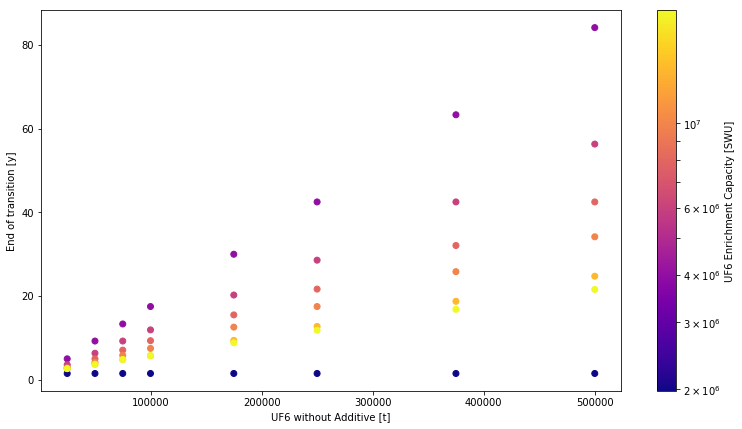

In [46]:
fig, ax = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 without Additive [t]")
plt.ylabel("End of transition [y]")
z_colors = thr_colors
sp = ax.scatter(x=x_unblended, y=y_time, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar = fig.colorbar(sp, label="UF6 Enrichment Capacity [SWU]")
#tt = cbar.ax.set_yticklabels(['', '', '5e5', '','', '', '', '1e6','2e6'])

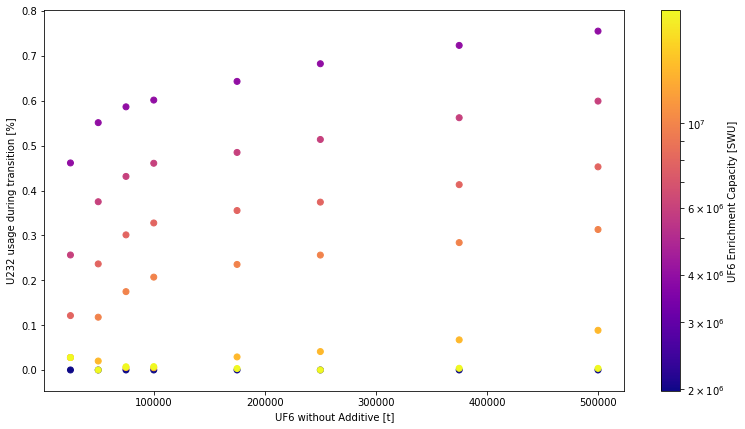

In [47]:

fig, ax2 = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 without Additive [t]")
plt.ylabel("U232 usage during transition [%]")
z_colors = thr_colors

ax2.scatter(x=x_unblended, y=ratio, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label="UF6 Enrichment Capacity [SWU]")
#tt = cbar.ax.set_yticklabels(['', '', '5e5', '','', '', '', '1e6','2e6'])

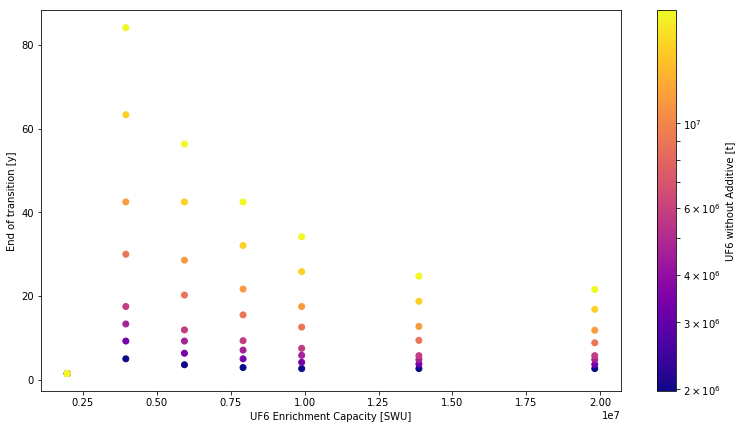

In [48]:
fig, ax_b = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 Enrichment Capacity [SWU]")
plt.ylabel("End of transition [y]")
z_colors = blend_colors
ax_b.scatter(x=thr_blend, y=y_time, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label='UF6 without Additive [t]')
#tt = cbar.ax.set_yticklabels(['', '', '5e5', '','', '', '', '1e6','2e6'])

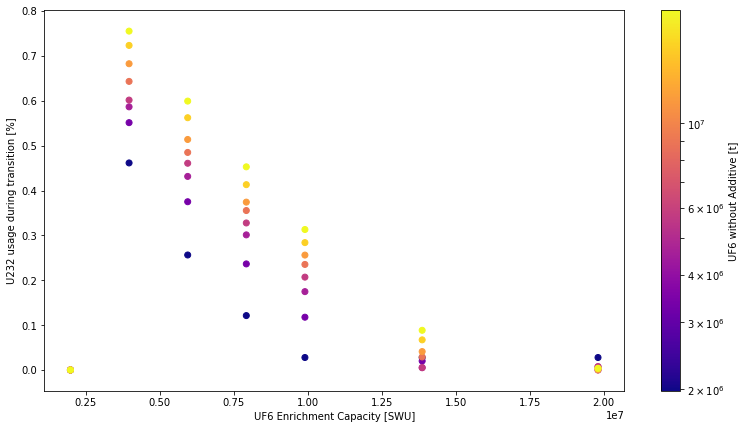

In [49]:
fig, ax2_b = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 Enrichment Capacity [SWU]")
plt.ylabel("U232 usage during transition [%]")
z_colors = blend_colors

ax2_b.scatter(x=thr_blend, y=ratio, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label='UF6 without Additive [t]')


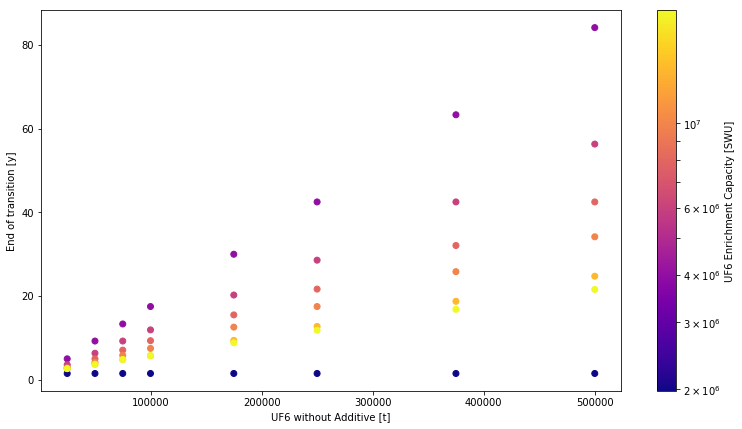

In [50]:
fig, ax = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 without Additive [t]")
plt.ylabel("End of transition [y]")
z_colors = thr_colors
sp = ax.scatter(x=x_unblended, y=y_time, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar = fig.colorbar(sp, label="UF6 Enrichment Capacity [SWU]")

In [151]:
x_unblended = [] #[x/1000 for x in unblended_list]
thr_blend = [] # [x*7.923 for x in throughput_list] #Why 7.923
x_growth = []
#growth_index
#throughput_list = [2.5e5, 5e5, 7.5e5, 1e6, 1.25e6, 1.75e6, 2.5e6]
u = throughput_map[2.5e6]

y_time = []
ratio = []
for i, unblended in enumerate(unblended_list):
    for j, growth in enumerate(growth_list):
        x_unblended.append(unblended/1000)
        x_growth.append(growth*100)
        ratio.append(output_ratio[i,u,j])
        y_time.append(output_eq_time[i,u,j])
growth_colors = np.array([x for x in x_growth])
blend_colors = np.array([x for x in x_unblended])
print(growth_colors.min())

0.0


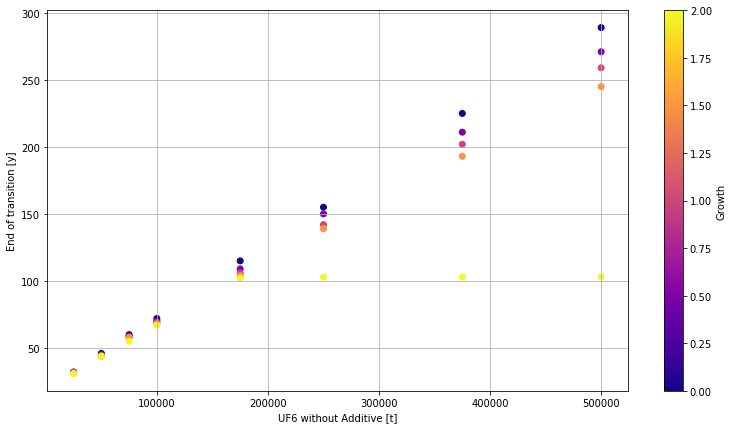

In [152]:
fig, ax = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 without Additive [t]")
plt.ylabel("End of transition [y]")
z_colors = growth_colors
sp = ax.scatter(x=x_unblended, y=y_time, c=z_colors, norm=colors.Normalize(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar = fig.colorbar(sp, label="Growth")
plt.grid()

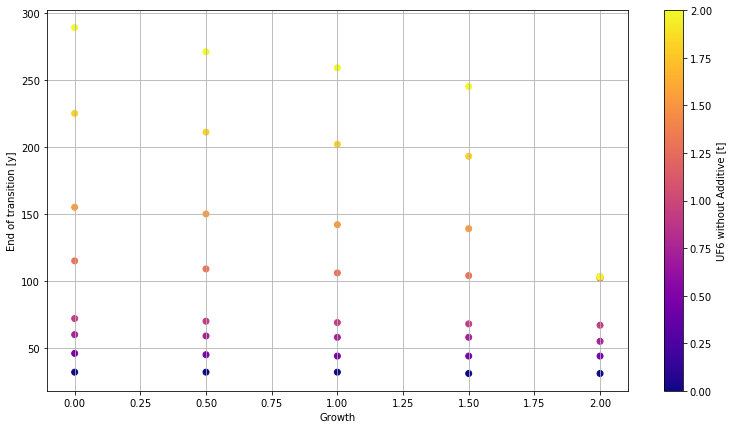

In [153]:
fig, ax_b = plt.subplots(figsize=(13,7))
plt.xlabel("Growth")
plt.ylabel("End of transition [y]")
z_colors = blend_colors
ax_b.scatter(x=x_growth, y=y_time, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar = fig.colorbar(sp, label='UF6 without Additive [t]')
plt.grid()